In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from textblob import TextBlob
from dateutil import parser
import re

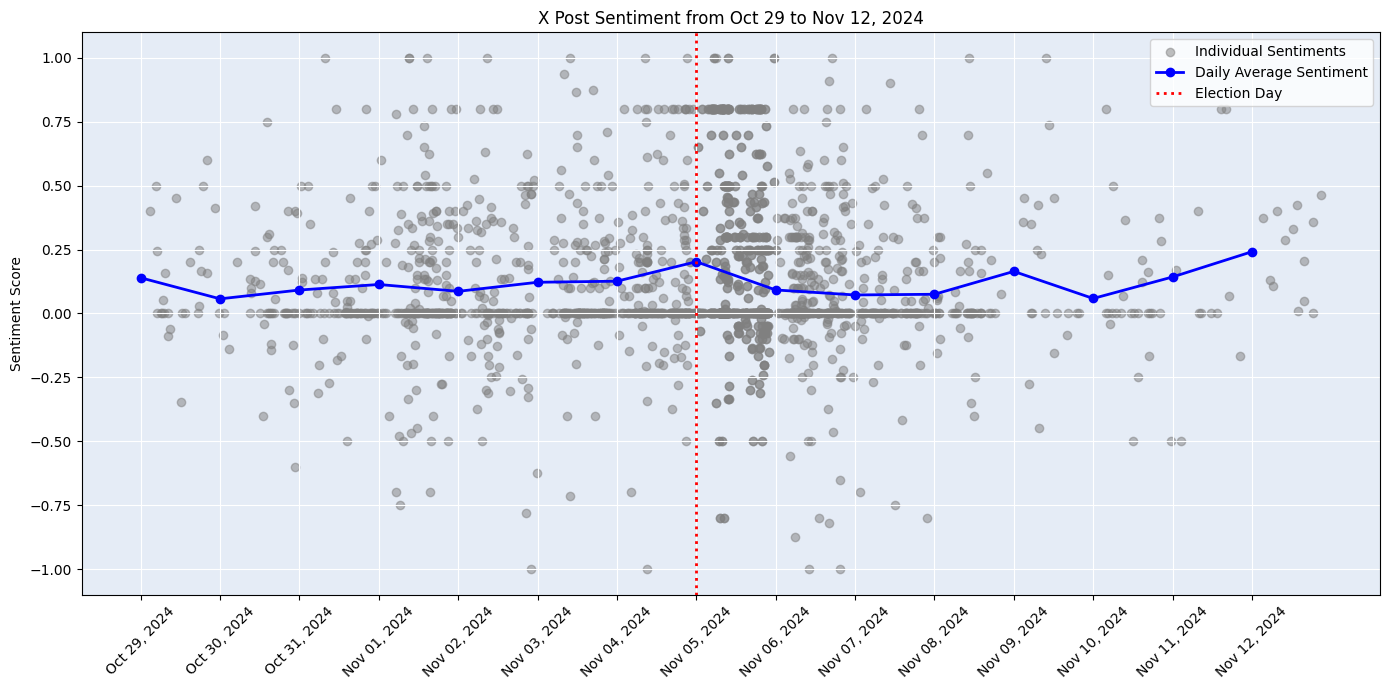

In [2]:
# Function to check if text is mostly English based on ASCII
def is_mostly_english(text, threshold=0.8):
    if not isinstance(text, str) or not text.strip():
        return False
    english_chars = sum(1 for c in text if c.isascii())
    return (english_chars / len(text)) >= threshold if len(text) > 0 else False

# Function to clean content
def clean_content(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Function to preprocess dataset
def preprocess_tweets(df, content_col="content", date_col="tweetDate"):
    # Ensure unique columns
    df = df.loc[:, ~df.columns.duplicated()]

    # Drop rows where tweetDate is missing
    df = df.dropna(subset=[date_col])

    # Convert date column to datetime with UTC timezone
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', utc=True)

    # Drop any remaining NaT
    df = df.dropna(subset=[date_col])

    # Remove duplicate tweets and drop missing content
    df = df.drop_duplicates(subset=[content_col])
    df = df.dropna(subset=[content_col])

    # Extract hashtags, mentions, and links from content
    df['hashtags'] = df[content_col].str.findall(r"#\w+")
    df['mentions'] = df[content_col].str.findall(r"@\w+")
    df['links'] = df[content_col].str.findall(r"https?://\S+")

    # Apply cleaning function to content
    df['cleaned_content'] = df[content_col].apply(clean_content)

    # Detect and filter only mostly English text
    df = df[df['cleaned_content'].apply(is_mostly_english)]

    # Drop original 'content' column and rename 'cleaned_content' to 'content'
    df = df.drop(columns=[content_col]).rename(columns={'cleaned_content': 'content'})

    return df

# Load datasets
tweets_before = pd.read_csv("tweets_before.csv")
tweets_after = pd.read_csv("tweets_after.csv")

# Ensure no duplicate column names in tweets_after
tweets_after = tweets_after.loc[:, ~tweets_after.columns.duplicated()]

# Rename columns in tweets_after to match tweets_before
tweets_after.rename(columns={'timestamp': 'tweetDate', 'caption': 'content'}, inplace=True)

# Select necessary columns for consistency
tweets_after = tweets_after[['tweetDate', 'content']]

# Apply preprocessing to both datasets
tweets_before = preprocess_tweets(tweets_before, content_col="content", date_col="tweetDate")
tweets_after = preprocess_tweets(tweets_after, content_col="content", date_col="tweetDate")

# Merge datasets
df = pd.concat([tweets_before, tweets_after])

# Convert tweetDate to datetime format
df['tweetDate'] = pd.to_datetime(df['tweetDate'], errors='coerce', utc=True)

# Drop any remaining NaT
df = df.dropna(subset=['tweetDate'])

# Ensure date filtering works
start_date = pd.Timestamp('2024-10-29', tz='UTC')
end_date = pd.Timestamp('2024-11-13', tz='UTC')

# Filter date range
df_filtered = df[(df['tweetDate'] >= start_date) & (df['tweetDate'] <= end_date)].copy()

# Function to get sentiment polarity using TextBlob
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Apply sentiment analysis to cleaned content
df_filtered['sentiment'] = df_filtered['content'].apply(get_sentiment)

# Extract date and calculate daily weighted sentiment
df_filtered['date'] = df_filtered['tweetDate'].dt.date

# Compute the daily average sentiment
daily_sentiment = df_filtered.groupby('date')['sentiment'].mean().reset_index()

# Convert date back to datetime for plotting
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Plot
plt.figure(figsize=(14, 7))
plt.gca().set_facecolor("#E5ECF6")

plt.scatter(df_filtered['tweetDate'], df_filtered['sentiment'], alpha=0.5, label='Individual Sentiments', color='gray')
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment'], marker='o', linestyle='-', color='blue', linewidth=2, label='Daily Average Sentiment')
plt.axvline(pd.Timestamp('2024-11-05'), color='red', linestyle=':', linewidth=2, label='Election Day')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.xticks(daily_sentiment['date'], rotation=45)
plt.xlabel(None)
plt.ylabel("Sentiment Score")
plt.title("X Post Sentiment from Oct 29 to Nov 12, 2024")
plt.legend()
plt.grid(True, color='white', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

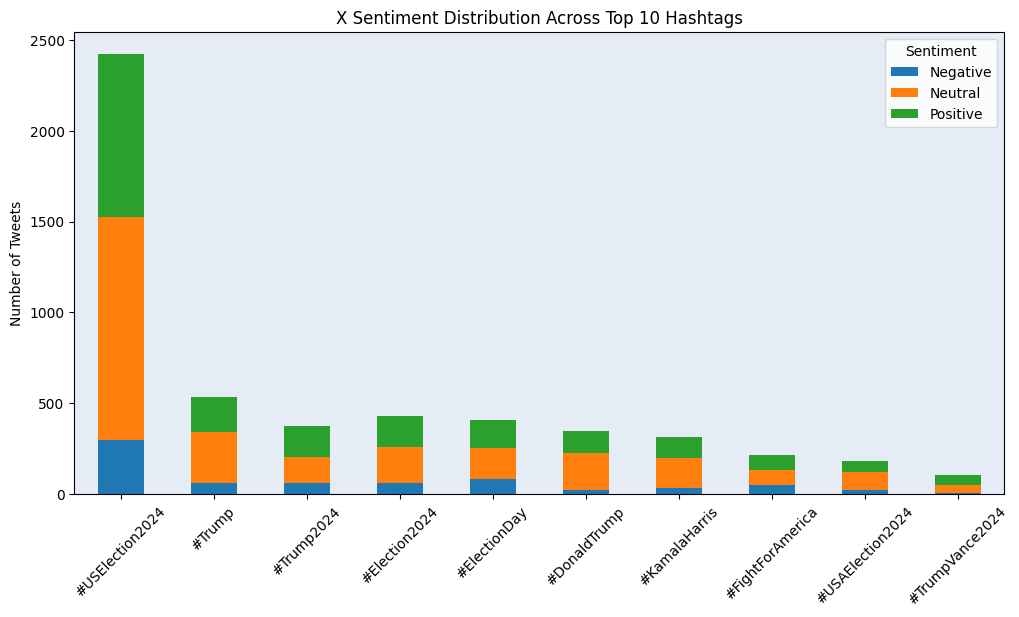

In [3]:
# Reoad dataset
tweets_df = pd.read_csv("tweets.csv")

# Extract hashtags from 'content'
tweets_df['hashtags'] = tweets_df['content'].apply(lambda x: re.findall(r"#\w+", str(x)))

# Flatten list of hashtags and count occurrences
hashtags_series = tweets_df['hashtags'].explode().dropna()
hashtag_counts = hashtags_series.value_counts()

# Function to determine sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis to the 'content' column
tweets_df['sentiment'] = tweets_df['content'].apply(get_sentiment)

# Create a DataFrame that maps each hashtag to its corresponding sentiment
hashtag_sentiment_df = tweets_df.explode('hashtags')[['hashtags', 'sentiment']].dropna()

# Count occurrences of each hashtag by sentiment
hashtag_sentiment_counts = hashtag_sentiment_df.groupby(['hashtags', 'sentiment']).size().unstack(fill_value=0)

# Display top hashtags based on breakdown
top_hashtags = hashtag_sentiment_counts.sort_values(by=['Positive', 'Negative', 'Neutral'], ascending=False).head(10)

# Plot sentiment distribution
top_hashtags.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.gca().set_facecolor("#E5ECF6")
plt.title("X Sentiment Distribution Across Top 10 Hashtags")
plt.xlabel(None)
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.show()